<a href="https://colab.research.google.com/github/royam0820/fastai2-v4/blob/master/GPT2_FR_TextClassification_allocine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OpenAI GPT2 model Infos
[Model Info](https://huggingface.co/transformers/model_doc/gpt2.html)

[The Illustrated GPT-2 (Visualizing Transformer Language Models)](http://jalammar.github.io/illustrated-gpt2/#model-output)

GPT-2 is a large transformer-based language model with **1.5 billion parameters**, trained on a dataset of 8 million web pages. GPT-2 is trained with a simple objective: predict the next word, given all of the previous words within some text. 

 


# Infos Notebook

This notebook is used to fine-tune GPT2 model for text classification using Huggingface transformers library on a custom dataset.

For the dataset, we are using the French AlloCine reviews, which are French reviews on films. 

Main idea: is to use a GPT2 model that has been pretrained with French texts, and then fine-tune this language model on a sub-domain which are the French reviews from AlloCine website.


In [1]:
# !nvidia-smi

In [2]:
! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab

     |████████████████████████████████| 204kB 13.7MB/s 
     |████████████████████████████████| 61kB 10.0MB/s 


In [3]:
!pip install -Uq transformers
from fastai.text.all import *

     |████████████████████████████████| 2.3MB 15.0MB/s 
     |████████████████████████████████| 901kB 49.7MB/s 
     |████████████████████████████████| 3.3MB 48.7MB/s 


# BelGPT-2 - a GPT-2 model pre-trained on French corpora
This language model has been trained on French texts from different sources: Wikipedia, news, EuroParl texts. Its size is 60Gb.

https://github.com/antoiloui/belgpt2/blob/master/docs/index.md

https://huggingface.co/antoiloui/belgpt2



In [4]:
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification, GPT2Config

In [5]:
model_name = "antoiloui/belgpt2"
max_len = 256
bs = 4

lr = 2e-5

In [6]:
#tokenizer = GPT2Tokenizer.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name, pad_token='<pad>')
tokenizer.padding_side = "left"
tokenizer.model_max_len = 512
model = GPT2ForSequenceClassification.from_pretrained(model_name)

Some weights of the model checkpoint at antoiloui/belgpt2 were not used when initializing GPT2ForSequenceClassification: ['lm_head.weight']
- This IS expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at antoiloui/belgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
model.config

GPT2Config {
  "_name_or_path": "antoiloui/belgpt2",
  "_num_labels": 2,
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "gradient_checkpointing": false,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "output_past": true,
  "resid_pdrop": 0.1,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "transformers_version": "4.6.1",
  "use_cache": true,
  "vocab_size": 50257
}

### Allocine Dataset

In [8]:
#creating a directory allocine
path = Path('/content/allocine/')
path.mkdir(parents=True, exist_ok=True)

In [9]:
#creating a directory allocine
path = Path('/content/allocine/models')
path.mkdir(parents=True, exist_ok=True)

In [10]:
path = Path('/content/allocine/'); path

Path('/content/allocine')

In [13]:
# downloading the AlloCine dataset
!wget -q https://github.com/TheophileBlard/french-sentiment-analysis-with-bert/raw/master/allocine_dataset/data.tar.bz2
!tar -xf /content/data.tar.bz2 -C '/content/allocine'

In [14]:
train_df = pd.read_json(path/'data/train.jsonl', lines=True, nrows=10000)
train_df.head(1)

,film-url,review,polarity
0,http://www.allocine.fr/film/fichefilm-135259/critiques/spectateurs,"Si vous cherchez du cinéma abrutissant à tous les étages,n'ayant aucune peur du cliché en castagnettes et moralement douteux,""From Paris with love"" est fait pour vous.Toutes les productions Besson,via sa filière EuropaCorp ont de quoi faire naître la moquerie.Paris y est encore une fois montrée comme une capitale exotique,mais attention si l'on se dirige vers la banlieue,on y trouve tout plein d'intégristes musulmans prêts à faire sauter le caisson d'une ambassadrice américaine.Nauséeux.Alors on se dit qu'on va au moins pouvoir apprécier la déconnade d'un classique buddy-movie avec le jeun...",0


In [15]:
train_df.to_csv(path/'data/train.csv', encoding = 'utf-8', header = True, index = False)
train_df.head(2)

,film-url,review,polarity
0,http://www.allocine.fr/film/fichefilm-135259/critiques/spectateurs,"Si vous cherchez du cinéma abrutissant à tous les étages,n'ayant aucune peur du cliché en castagnettes et moralement douteux,""From Paris with love"" est fait pour vous.Toutes les productions Besson,via sa filière EuropaCorp ont de quoi faire naître la moquerie.Paris y est encore une fois montrée comme une capitale exotique,mais attention si l'on se dirige vers la banlieue,on y trouve tout plein d'intégristes musulmans prêts à faire sauter le caisson d'une ambassadrice américaine.Nauséeux.Alors on se dit qu'on va au moins pouvoir apprécier la déconnade d'un classique buddy-movie avec le jeun...",0
1,http://www.allocine.fr/film/fichefilm-172430/critiques/spectateurs,"Trash, re-trash et re-re-trash...! Une horreur sans nom. Imaginez-vous les 20 premières minutes de Orange Mécanique dilatées sur plus de 70 minutes de bande VHS pourrave et revisitées par Korine à la sauce années 2000 : les dandys-punk de Kubrick ont laissé place à des papys lubriques déguisés en sacs-poubelles forniquant les troncs d'arbres, le dispositif esthétique se résume à du filmage-réalité enfilant des scènes de destruction, de soumission, de pornographie ou encore de maltraitance ( youtube, youtube et re-youtube...) et la bande-son se limite à des ricanements malades, des rengaine...",0


In [16]:
# # splitting a df by rows
# df_train = df.iloc[10001:-1]; len(df_train)

## Text Tokenization

In [17]:
tokenizer.vocab_size

50257

In [18]:
tokenizer.pad

<bound method PreTrainedTokenizerBase.pad of PreTrainedTokenizer(name_or_path='antoiloui/belgpt2', vocab_size=50257, model_max_len=1000000000000000019884624838656, is_fast=False, padding_side='left', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<pad>'})>

In [19]:
print(tokenizer.eos_token)
print(tokenizer.bos_token)

<|endoftext|>
<|endoftext|>


In [20]:
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): 
        toks = self.tokenizer.tokenize(x)
        return TensorText(self.tokenizer.convert_tokens_to_ids(toks))
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))


In [21]:
# testing the tokenizer 
tokenizer_fastai_fr = TransformersTokenizer(tokenizer)
text = "Peut-être que vous avez raison"
tokens_ids = tokenizer_fastai_fr.encodes(text)
tokens = tokenizer_fastai_fr.tokenizer.convert_ids_to_tokens(tokens_ids)

print('input text:',TitledStr(text))
print('text tokens:',TitledStr(tokens))
print('text tokens_ids:',TitledStr(tokens_ids))
print('output text:',TitledStr(tokenizer_fastai_fr.decodes(tokens_ids)))

input text: Peut-être que vous avez raison
text tokens: ['Peut', '-', 'Ãªtre', 'Ġque', 'Ġvous', 'Ġavez', 'Ġraison']
text tokens_ids: TensorText([46906,    15,  1519,   354,   472,  1578,  1835])
output text: Peut-être que vous avez raison


## DataLoader

In [22]:
bs

4

In [23]:
# bs,sl = 8, 256

In [24]:
class HFTextBlock(TransformBlock):
    "A `TransformBlock` for texts"
    def __init__(self, tokenizer):
        type_tfms = TransformersTokenizer(tokenizer)
        pad_first = tokenizer.padding_side == 'left'
        #pad_first = tokenizer.padding_side=='left')
        return super().__init__(type_tfms=type_tfms,
                                dl_type= SortedDL,
                                dls_kwargs={'before_batch':Pad_Chunk(pad_idx = tokenizer.pad_token_id, pad_first=(tokenizer.padding_side=='left'))})
        

In [25]:
dls_clas = DataBlock(
        blocks=(HFTextBlock(tokenizer), CategoryBlock),
        get_y=ColReader('polarity'), 
        get_x=ColReader('review'), 
        splitter=RandomSplitter(),

).dataloaders(train_df, bs=4)

In [26]:
# xb,yb=dls_clas.one_batch()

NOTE:  Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.

Using pad_token, but it is not set yet.
Could not do one pass in your dataloader, there is something wrong in it

CPU times: user 10.4 s, sys: 35.5 ms, total: 10.4 s
Wall time: 10.5 s

In [27]:
dls_clas.show_batch(max=3)

,text,category
0,"Le souffle d’une peau blême laisse vibrer sur la platitude de l’écran les vrombissements intimes de l’érotisme. «The Docks of New York» (USA, 1928) de Josef von Sternberg délaissent les corps et leur chair dans les brumes opaques des ports marins. La poudre qui recouvre le corps mutique de Betty Compson l’a confond avec la pâleur éblouissante des angelots de Michel-Ange. Cette connivence ne va pas plus loin. L’innocence des chérubins est absente du corps de Mae au profit d’une sensibilité lubrique. Les jeux de séduction que se livre Compson et l’imposant Geroge Bancroft se résume à la correspondance de la peau féminine frêle et incandescente avec les yeux masculins limpides. Un objet du désir, le corps de la femme, se mue en écran (en adopte du moins les caractéristiques blafarde) pour mieux se laisser voir, admirer, palper et convoiter par le regard de l’homme. Sternberg, à l’orée de la",1
1,"En lisant les critiques presses d'Allociné je n'ai pu réprimer un sourire narquois doublé d'une profonde exaspération. Tant de bêtise, c'est presque inhumain. On parle d'expérimental? De Palme d'Or? D'Antonioni? Arrêtons les fantasmes. Mieux encore : « «Millennium Mambo» va encore plus loin dans une voie où l'abstraction géométrique n'empêche pas mais nourrit la précision réaliste, où l'artifice parvient à atteindre la vérité », signé Le Monde. Ou comment décrire du vide en disant du vide... «Millennium Mambo» ou de l'uniformisation des cultures. Car au fond c'est la seule vraie qualité du long métrage, montrer qu'aujourd'hui à Taïwan la vie d'une jeune fille d'une vingtaine d'années est incroyablement similaire à celle des jeunes européen(ne)s, et sans doute des jeunes américain(e)s du même âge. Hou Hsiao Hsien voulait rendre compte du mode de vie de la jeunesse de son pays, il l'a fait avec brio, simplicité et efficacité. Le style rappelle",0
2,"Pour « Voyage en Italie » Roberto Rossellini réutilise le style néo-réaliste qu’il à inauguré avec « Rome : Ville Ouvert ». Mais contrairement à ce dernier, cette fois, le cinéaste ne nous décrire pas la situation social des citoyens Italiens pendant la guerre. Il préfère nous raconter une histoire de couple. Un couple qui quitte l’Angleterre pour passer quelque jour en Italie. Sauf qu’une fois que ni le quotidien, ni le travaille ne peut s’interposé entre eux deux, ils se rendent compte que leurs relation tourne à vide. Ils ont l’impression de se voir pour la première fois. La détresse de ses deux âme grisé est si finement décrite que le spectateur en est déstabilisé de réalisme. Tout sonne juste et vrai. Il s’agit ici d’un réel coup de maitre de la part Rossellini. Et puis il y a Ingrid Bergman, la muse et femme du réalisateur, au sommé",1
3,"Le copyright du film appartient à la Sherwood baptist church of Albany, Georgia. La messe est dite, mais pour ceux qui s'aventureront à regarder ce film, préparez vous à l'entendre (la messe) pendant 1h20 (sur 1h45). Pourtant ça commence de façon sympa et l'empathie fonctionne avec ce mec qui a une femme qui l'aime (le plus important) mais qui vit aussi en joignant tout juste les deux bouts, qui accumule les echecs dans sa vie professionnelle et qui se révèle incapable d'avoir des enfants (il est stérile). De tout cela, s'il avait réussi à améliorer, à force d'effort et de volonté, un seul de ses problèmes, ça aurait suffit pour rendre le film agréable (pas fantastique, les acteurs sont moyens, tout comme les scènes sportives). Non, il redécouvre sa foi en Dieu et Jésus (contrairement à ce que dit une critique 4 étoiles, si c'est clairement chrétien, et même évangéliste",0


In [28]:
print(len(dls_clas.train), len(dls_clas.valid))

2000 500


In [29]:
dls_clas.c, dls_clas.vocab

(2, [0, 1])

# CUDA out of memory.

In [30]:
# del learn
# del model_name
# torch.cuda.empty_cache()
# import gc
# gc.collect()

## Text Learner

In [31]:
def default_splitter(model):
    groups = L(model.base_model.children()) + L(m for m in list(model.children())[1:] if params(m))
    return groups.map(params)

In [32]:
class DropOutput(Callback):
    def after_pred(self): self.learn.pred = self.pred[0]

In [33]:
model = GPT2ForSequenceClassification.from_pretrained(model_name, pad_token_id=tokenizer.pad_token_id)
learn = Learner(dls_clas, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=accuracy).to_fp16() 

Some weights of the model checkpoint at antoiloui/belgpt2 were not used when initializing GPT2ForSequenceClassification: ['lm_head.weight']
- This IS expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at antoiloui/belgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
learn.model

GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=Fal

In [35]:
# learn.lr_find()

In [36]:
learn.fit_one_cycle(1, lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.154034,0.148432,0.947500,03:00


## Evaluate

In [37]:
# amr predicting sentiment analysis
learn.predict("Ce film est vraiment marrant")
#learn.predict("Ce film est un navet")

('1', TensorText(1), TensorText([0.0129, 0.9871]))

In [38]:
# amr predicting sentiment analysis
#learn.predict("Ce film est vraiment marrant")
learn.predict("Ce film est un navet")

('0', TensorText(0), TensorText([0.9796, 0.0204]))

In [39]:
learn.show_results()

,text,category,category_
0,"Bon, c'est vrai que ça sentait pas très bon à première vue, mais l'appel des nouveaux implants capillaires de Nicolas Cage (ici en chanteur de Nickelback) a été le plus fort. Mais bon, à part ça : ouille que ça pique aux yeux! Les dix premières minutes suffisent à poser les bases : un fantastique de pacotille brodé par une intrigue brouillonne durant laquelle on voit pleins de gars se balancer des boules de feux ; mais aussi des très risibles « Horvath, tu m'as trahi! » lâchés sur un simple regard par un Merlin (oui oui, il est là...) à la voix de golgoth, le tout sur fond d'une Monica Belucci qui ne fera qu'une brève apparition juste le temps de se faire emprisonner dans une « gigogne » (oui, c'est un mot que j'ai découvert moi aussi, mais il faudra s'y faire : le film regorgeant de «",0,0
1,"Voilà un film totalement barré où on se perd dans l’intrigue. Si c’est ce que voulaient les scénaristes, les monteurs et le réalisateur, alors ils ont réussi brillamment leur pari, à l’image de Dorothy Macha (Ray Liotta). Personnellement, j’ai une sainte horreur d’être perdu dans un film en apparence décousu, tant les plans peuvent être démultipliés sur une scène qui ne tient qu’en quelques mots. En effet, ces plans sont mélangés dans la chronologie des faits, seulement pour récupérer les propos pour en faire une réplique à la logique schizophrénique. Une logique que je conteste car je me suis (encore une fois, j’insiste) perdu et, je l’avoue, désintéressé du film. Lobotomisé par ce style anarchique, il fallait que je sache quand même le fin mot de l’histoire, et je dois reconnaître que le traitement et le ton adopté sont à l’image des personnages. Tout est complètement barré, me rappelant un",0,0
2,"Difficile de prendre au sérieux ""Le bras de la vengeance"", un des films les plus connus d'arts martiaux Hong-Kongais. Si le kitsch de certains films provoque parfois la tendresse du spectateur, c'est ici l'ennui et la distance qui saisissent ce dernier. On se rend compte que le film a vraiment mal vieilli quand on voit le traitement réservé aux phases imaginatives de Fang avec flou et ralenti les cheveux au vent, le traitement du son avec des bruitages exacerbés et invraisemblables (roues tranchantes). Il ressort de ce film une impression de factice à tous les niveaux car au-delà des extérieurs parfois en studio ce sont les artifices visuels qui sont mis en cause. Que ce soit le maquillage grossier du ""chevalier blanc"" (du talc sur le visage?), l'utilisation du câble ou la scène surréaliste où Fang corrige une dizaine de guerriers avec une fine et petite branche d'arbre, on ne",0,0
3,"Colter Stevens se réveille en sursaut dans un train à destination de Chicago. Amnésique, il n’a aucun souvenir d’être monté dedans. Pire encore, les passagers du train se comportent avec lui avec familiarité alors qu’il ne les a jamais vus. Désorienté, il cherche à comprendre ce qui se passe mais une bombe explose tuant tout le monde à bord. Colter se réveille alors dans un caisson étrange et découvre qu’il participe à un procédé expérimental permettant de se projeter dans le corps d’une personne et de revivre les 8 dernières minutes de sa vie. Sa mission : revivre sans cesse les quelques minutes précédant l’explosion afin d’identifier et d’arrêter les auteurs de l’attentat. A chaque échec, les chances de pouvoir revenir dans le passé s’amenuisent. Alors qu’il essaie d’empêcher l’explosion, ses supérieurs lui apprennent qu’un deuxième attentat est en préparation en plein cœur de Chicago et qu’il ne s’agit plus",1,1


In [40]:
from fastai.interpret import *
#interp = Interpretation.from_learner(learn)
interp = ClassificationInterpretation.from_learner(learn)

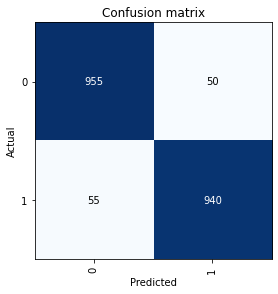

In [41]:
interp.plot_confusion_matrix()

In [42]:
interp.plot_top_losses(9, figsize=(15,11))

,input,target,predicted,probability,loss
0,"Un très bon film, très drôle, une heure et demie de détente sure. Tous les acteurs jouent formidablement pour nous offrir le renouement d'un nouveau groupe de rock. Bravo tout particulièrement à Eléonore Pourriat et Juie Depardieu. Film à voir et à délecter avec humour.",0,1,0.9994450211524963,7.496648788452148
1,Cette production présente suffisamment d’intérêt pour vous faire oublier vos enfants/votre conjoint/votre plat au four (rayez la mention inutile) le temps d'une soirée.,1,0,0.9986087679862976,6.577564239501953
2,alors une fois vu les comédie musical a Londres ceux de France je les trouve nul la je suis allez voir en me disant encore une comédie musical nul ben bravo obispo et toute la troupe enfin une comédie musical a la hauteur de celle que savait vu a Londres et j'espère même venir vous voir en live si j'arrive a trouve des place du début jusque a la fin s'était dedans a si un defaux trop court sa passe trop vite,1,0,0.9985306262969971,6.522954940795898
3,"""Le peuple des ténèbres"" ou le film qui vous rend visite la nuit. Terreurs nocturnes, visiteurs aguerris nous font trembler ainsi que l'interprétation (non sans faille) de Laura Regan. La psychologie des personnages : deux très bons points ; idée de scénario et scénariste : -2 ; effets spéciaux : + 1 ; jeu des acteurs : -1 ; reste un final éblouissant et merveilleux qui nous fait rebondir : + 5 points. Total : 5 points. On reste sur notre faim...",0,1,0.9952632188796997,5.3524041175842285
4,"Deux personnages seulement pour ce film, un seul lieu, une chambre, où deux amants lors d'une nuit d'amour font part belle aux confessions. Un film donc entièrement dialogué, avec des conversations portant sur l'amour essentiellement, mais aussi sur la perversion, la vie etc... Ici, le cinéaste traduit sa vision des choses, de manière originale et précise. Un bon petit film, peu commun, avec deux bons acteurs.",0,1,0.9937950372695923,5.082396030426025
5,"Production Disney qui me toucha dans mon enfance, l'incroyable voyage reste toujours aussi émouvant. Les beaux paysages renforcent le côté aventurier de cette escapade animale. A noter les voix françaises de Jean Reno, Christian Clavier et Valérie Lemercier, le trio gagnant des Visiteurs. Amusant.",0,1,0.9910406470298767,4.715054512023926
6,"Destruction. Un homme aigri par son divorce pourtant à consentement mutuel dénigre son ex-femme et l'affaiblit jusqu'auprès de sa famille dans le but de récupérer leur fille. Richard Berry se montre odieux et Anne Brochet qui souhaitait retrouver son indépendance se voit confrontée à toute une série de mensonges et de bassesse. Il fait passer son ex-femme pour une mauvaise mère ayant une influence néfaste sur la vie de leur fille. Il abandonne la partie lorsqu'il apprend qu'il va de nouveau être père avec une jeune femme rencontrée entretemps. L'on suppose que Richard Berry va recommencer son manège car il souhaite avoir l'entière possession sur sa progéniture. Film âpre, mais réaliste sur les faits. A voir.",0,1,0.9831821918487549,4.085319995880127
7,Hilarant!!! c'est la comédie de l'été mais ce n'est pas non plus approprié pour les plus jeunes donc les parents faite attention ce n'est pas une comédie familiale.,1,0,0.9817181825637817,4.00184965133667
8,Intéressant. Bonne intrigue. Plutôt un téléfilm. J'ai aimé le côté narratif qui est bien mené. Les acteurs sont plutôt bon.,0,1,0.980820894241333,3.9539356231689453


## NOTE
https://github.com/huggingface/transformers/issues/2001

GPT2 has no padding token, as it was trained on documents and not sentences.
In order to use GPT2 with variable length inputs, we can apply padding with an arbitrary token and ensure that those tokens are not used by the model with an attention_mask.
As for the labels, we should replace only on the labels variable the padded token ids with -1.